# Solar Power Generation


## Preparation


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.optim as optim


for dirname, _, filenames in os.walk("./data"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/Plant_2_Generation_Data.csv
./data/Plant_1_Generation_Data.csv
./data/Plant_2_Weather_Sensor_Data.csv
./data/Plant_1_Weather_Sensor_Data.csv


In [2]:
# Data Loading
generation_data_plant_1 = pd.read_csv("./data/Plant_1_Generation_Data.csv")
weather_data_plant_1 = pd.read_csv("./data/Plant_1_Weather_Sensor_Data.csv")
generation_data_plant_2 = pd.read_csv("./data/Plant_2_Generation_Data.csv")
weather_data_plant_2 = pd.read_csv("./data/Plant_2_Weather_Sensor_Data.csv")

In [3]:
generation_data_plant_1_head = generation_data_plant_1.head()
weather_data_plant_1_head = weather_data_plant_1.head()
generation_data_plant_2_head = generation_data_plant_2.head()
weather_data_plant_2_head = weather_data_plant_2.head()

generation_data_plant_1_head, weather_data_plant_1_head
generation_data_plant_2_head, weather_data_plant_2_head

(             DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
 0  2020-05-15 00:00:00   4136001  4UPUqMRk7TRMgml       0.0       0.0   
 1  2020-05-15 00:00:00   4136001  81aHJ1q11NBPMrL       0.0       0.0   
 2  2020-05-15 00:00:00   4136001  9kRcWv60rDACzjR       0.0       0.0   
 3  2020-05-15 00:00:00   4136001  Et9kgGMDl729KT4       0.0       0.0   
 4  2020-05-15 00:00:00   4136001  IQ2d7wF4YD8zU1Q       0.0       0.0   
 
    DAILY_YIELD   TOTAL_YIELD  
 0  9425.000000  2.429011e+06  
 1     0.000000  1.215279e+09  
 2  3075.333333  2.247720e+09  
 3   269.933333  1.704250e+06  
 4  3177.000000  1.994153e+07  ,
              DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
 0  2020-05-15 00:00:00   4136001  iq8k7ZNt4Mwm3w0            27.004764   
 1  2020-05-15 00:15:00   4136001  iq8k7ZNt4Mwm3w0            26.880811   
 2  2020-05-15 00:30:00   4136001  iq8k7ZNt4Mwm3w0            26.682055   
 3  2020-05-15 00:45:00   4136001  iq8k7ZNt4Mwm3w0           

## Data Exploration


### Data Cleaning


In [4]:
generation_data_plant_1_missing_values = generation_data_plant_1.isnull().sum()
weather_data_plant_1_missing_values = weather_data_plant_1.isnull().sum()
generation_data_plant_2_missing_values = generation_data_plant_2.isnull().sum()
weather_data_plant_2_missing_values = weather_data_plant_2.isnull().sum()

print(generation_data_plant_1_missing_values)
print(weather_data_plant_1_missing_values)
print(generation_data_plant_2_missing_values)
print(weather_data_plant_2_missing_values)

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64
DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64
DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64
DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


In [5]:
# Convert DATE_TIME columns to datetime
generation_data_plant_1["DATE_TIME"] = pd.to_datetime(
    generation_data_plant_1["DATE_TIME"], format="%d-%m-%Y %H:%M"
)
weather_data_plant_1["DATE_TIME"] = pd.to_datetime(
    weather_data_plant_1["DATE_TIME"], format="%Y-%m-%d %H:%M:%S"
)
generation_data_plant_2["DATE_TIME"] = pd.to_datetime(
    generation_data_plant_2["DATE_TIME"], format="%Y-%m-%d %H:%M:%S"
)
weather_data_plant_2["DATE_TIME"] = pd.to_datetime(
    weather_data_plant_2["DATE_TIME"], format="%Y-%m-%d %H:%M:%S"
)

#### Plant 1


In [6]:
generation_data_plant_1.drop(["PLANT_ID"], axis=1, inplace=True)
weather_data_plant_1.drop(["PLANT_ID", "SOURCE_KEY"], axis=1, inplace=True)

generation_data_plant_1.head(), weather_data_plant_1.tail()

(   DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD
 0 2020-05-15  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6259559.0
 1 2020-05-15  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6183645.0
 2 2020-05-15  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6987759.0
 3 2020-05-15  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7602960.0
 4 2020-05-15  McdE0feGgRqW7Ca       0.0       0.0          0.0    7158964.0,
                DATE_TIME  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION
 3177 2020-06-17 22:45:00            22.150570           21.480377          0.0
 3178 2020-06-17 23:00:00            22.129816           21.389024          0.0
 3179 2020-06-17 23:15:00            22.008275           20.709211          0.0
 3180 2020-06-17 23:30:00            21.969495           20.734963          0.0
 3181 2020-06-17 23:45:00            21.909288           20.427972          0.0)

In [7]:
plant_1_data = generation_data_plant_1.merge(weather_data_plant_2, on="DATE_TIME")
print(plant_1_data.shape)

plant_1_generation_data_resampled = (
    plant_1_data[["DC_POWER", "AC_POWER", "DAILY_YIELD", "TOTAL_YIELD", "DATE_TIME"]]
    .resample("1T", on="DATE_TIME")
    .last()
)

plant_1_weather_data_resampled = (
    plant_1_data[
        ["AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "DATE_TIME"]
    ]
    .resample("1T", on="DATE_TIME")
    .mean()
)

plant_1_data = pd.concat(
    [plant_1_weather_data_resampled, plant_1_generation_data_resampled], axis=1
)
plant_1_data.reset_index(inplace=True)
plant_1_data.dropna(inplace=True)

print(plant_1_data.shape)
plant_1_data.tail()

(68708, 11)
(3154, 8)


,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
48885,2020-06-17 22:45:00,23.511703,22.856201,0.0,0.0,0.0,5910.0,7363272.0
48900,2020-06-17 23:00:00,23.482282,22.744190,0.0,0.0,0.0,5910.0,7363272.0
48915,2020-06-17 23:15:00,23.354743,22.492245,0.0,0.0,0.0,5910.0,7363272.0
48930,2020-06-17 23:30:00,23.291048,22.373909,0.0,0.0,0.0,5910.0,7363272.0
48945,2020-06-17 23:45:00,23.202871,22.535908,0.0,0.0,0.0,5910.0,7363272.0


#### Plant 2


In [8]:
generation_data_plant_2.drop(["PLANT_ID"], axis=1, inplace=True)
weather_data_plant_2.drop(["PLANT_ID", "SOURCE_KEY"], axis=1, inplace=True)

generation_data_plant_2.head(), weather_data_plant_2.tail()

(   DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD   TOTAL_YIELD
 0 2020-05-15  4UPUqMRk7TRMgml       0.0       0.0  9425.000000  2.429011e+06
 1 2020-05-15  81aHJ1q11NBPMrL       0.0       0.0     0.000000  1.215279e+09
 2 2020-05-15  9kRcWv60rDACzjR       0.0       0.0  3075.333333  2.247720e+09
 3 2020-05-15  Et9kgGMDl729KT4       0.0       0.0   269.933333  1.704250e+06
 4 2020-05-15  IQ2d7wF4YD8zU1Q       0.0       0.0  3177.000000  1.994153e+07,
                DATE_TIME  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION
 3254 2020-06-17 22:45:00            23.511703           22.856201          0.0
 3255 2020-06-17 23:00:00            23.482282           22.744190          0.0
 3256 2020-06-17 23:15:00            23.354743           22.492245          0.0
 3257 2020-06-17 23:30:00            23.291048           22.373909          0.0
 3258 2020-06-17 23:45:00            23.202871           22.535908          0.0)

In [9]:
plant_2_data = generation_data_plant_1.merge(weather_data_plant_2, on="DATE_TIME")
print(plant_2_data.shape)

plant_2_weather_data_resampled = (
    plant_2_data[
        ["AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "DATE_TIME"]
    ]
    .resample("1T", on="DATE_TIME")
    .mean()
)

plant_2_generation_data_resampled = (
    plant_2_data[["DC_POWER", "AC_POWER", "DAILY_YIELD", "TOTAL_YIELD", "DATE_TIME"]]
    .resample("1T", on="DATE_TIME")
    .last()
)

plant_2_data = pd.concat(
    [plant_2_weather_data_resampled, plant_2_generation_data_resampled], axis=1
)
plant_2_data.reset_index(inplace=True)
plant_2_data.dropna(inplace=True)

print(plant_2_data.shape)
plant_2_data.tail()

(68708, 9)
(3154, 8)


,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
48885,2020-06-17 22:45:00,23.511703,22.856201,0.0,0.0,0.0,5910.0,7363272.0
48900,2020-06-17 23:00:00,23.482282,22.744190,0.0,0.0,0.0,5910.0,7363272.0
48915,2020-06-17 23:15:00,23.354743,22.492245,0.0,0.0,0.0,5910.0,7363272.0
48930,2020-06-17 23:30:00,23.291048,22.373909,0.0,0.0,0.0,5910.0,7363272.0
48945,2020-06-17 23:45:00,23.202871,22.535908,0.0,0.0,0.0,5910.0,7363272.0


### Data Merging


In [10]:
data_combined = pd.concat([plant_1_data, plant_2_data], axis=0)

# Checking the structure of the combined data
data_combined_structure = data_combined.describe(
    include="all", datetime_is_numeric=True
)

data_combined_structure

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,6308,6308.000000,6308.000000,6308.000000,6308.000000,6308.000000,6308.000000,6.308000e+03
mean,2020-06-01 06:48:25.738744320,28.112948,32.929990,0.236539,3152.450610,308.274413,3323.801350,7.233472e+06
min,2020-05-15 00:00:00,20.942385,20.265123,0.000000,0.000000,0.000000,0.000000,6.240543e+06
25%,2020-05-23 23:15:00,24.616667,23.758779,0.000000,0.000000,0.000000,0.000000,7.180367e+06
50%,2020-06-01 12:37:30,27.102685,27.801562,0.026658,372.375000,35.968750,2648.562500,7.243875e+06
75%,2020-06-09 18:15:00,31.107021,40.670176,0.444852,6391.571429,626.057143,6317.500000,7.310451e+06
max,2020-06-17 23:45:00,39.181638,66.635953,1.098766,14329.142860,1397.085714,8842.000000,7.363272e+06
std,NaN,4.069442,11.365219,0.313653,4072.453711,397.886236,3185.109311,1.197065e+05


## Data plotting


### Line Chart


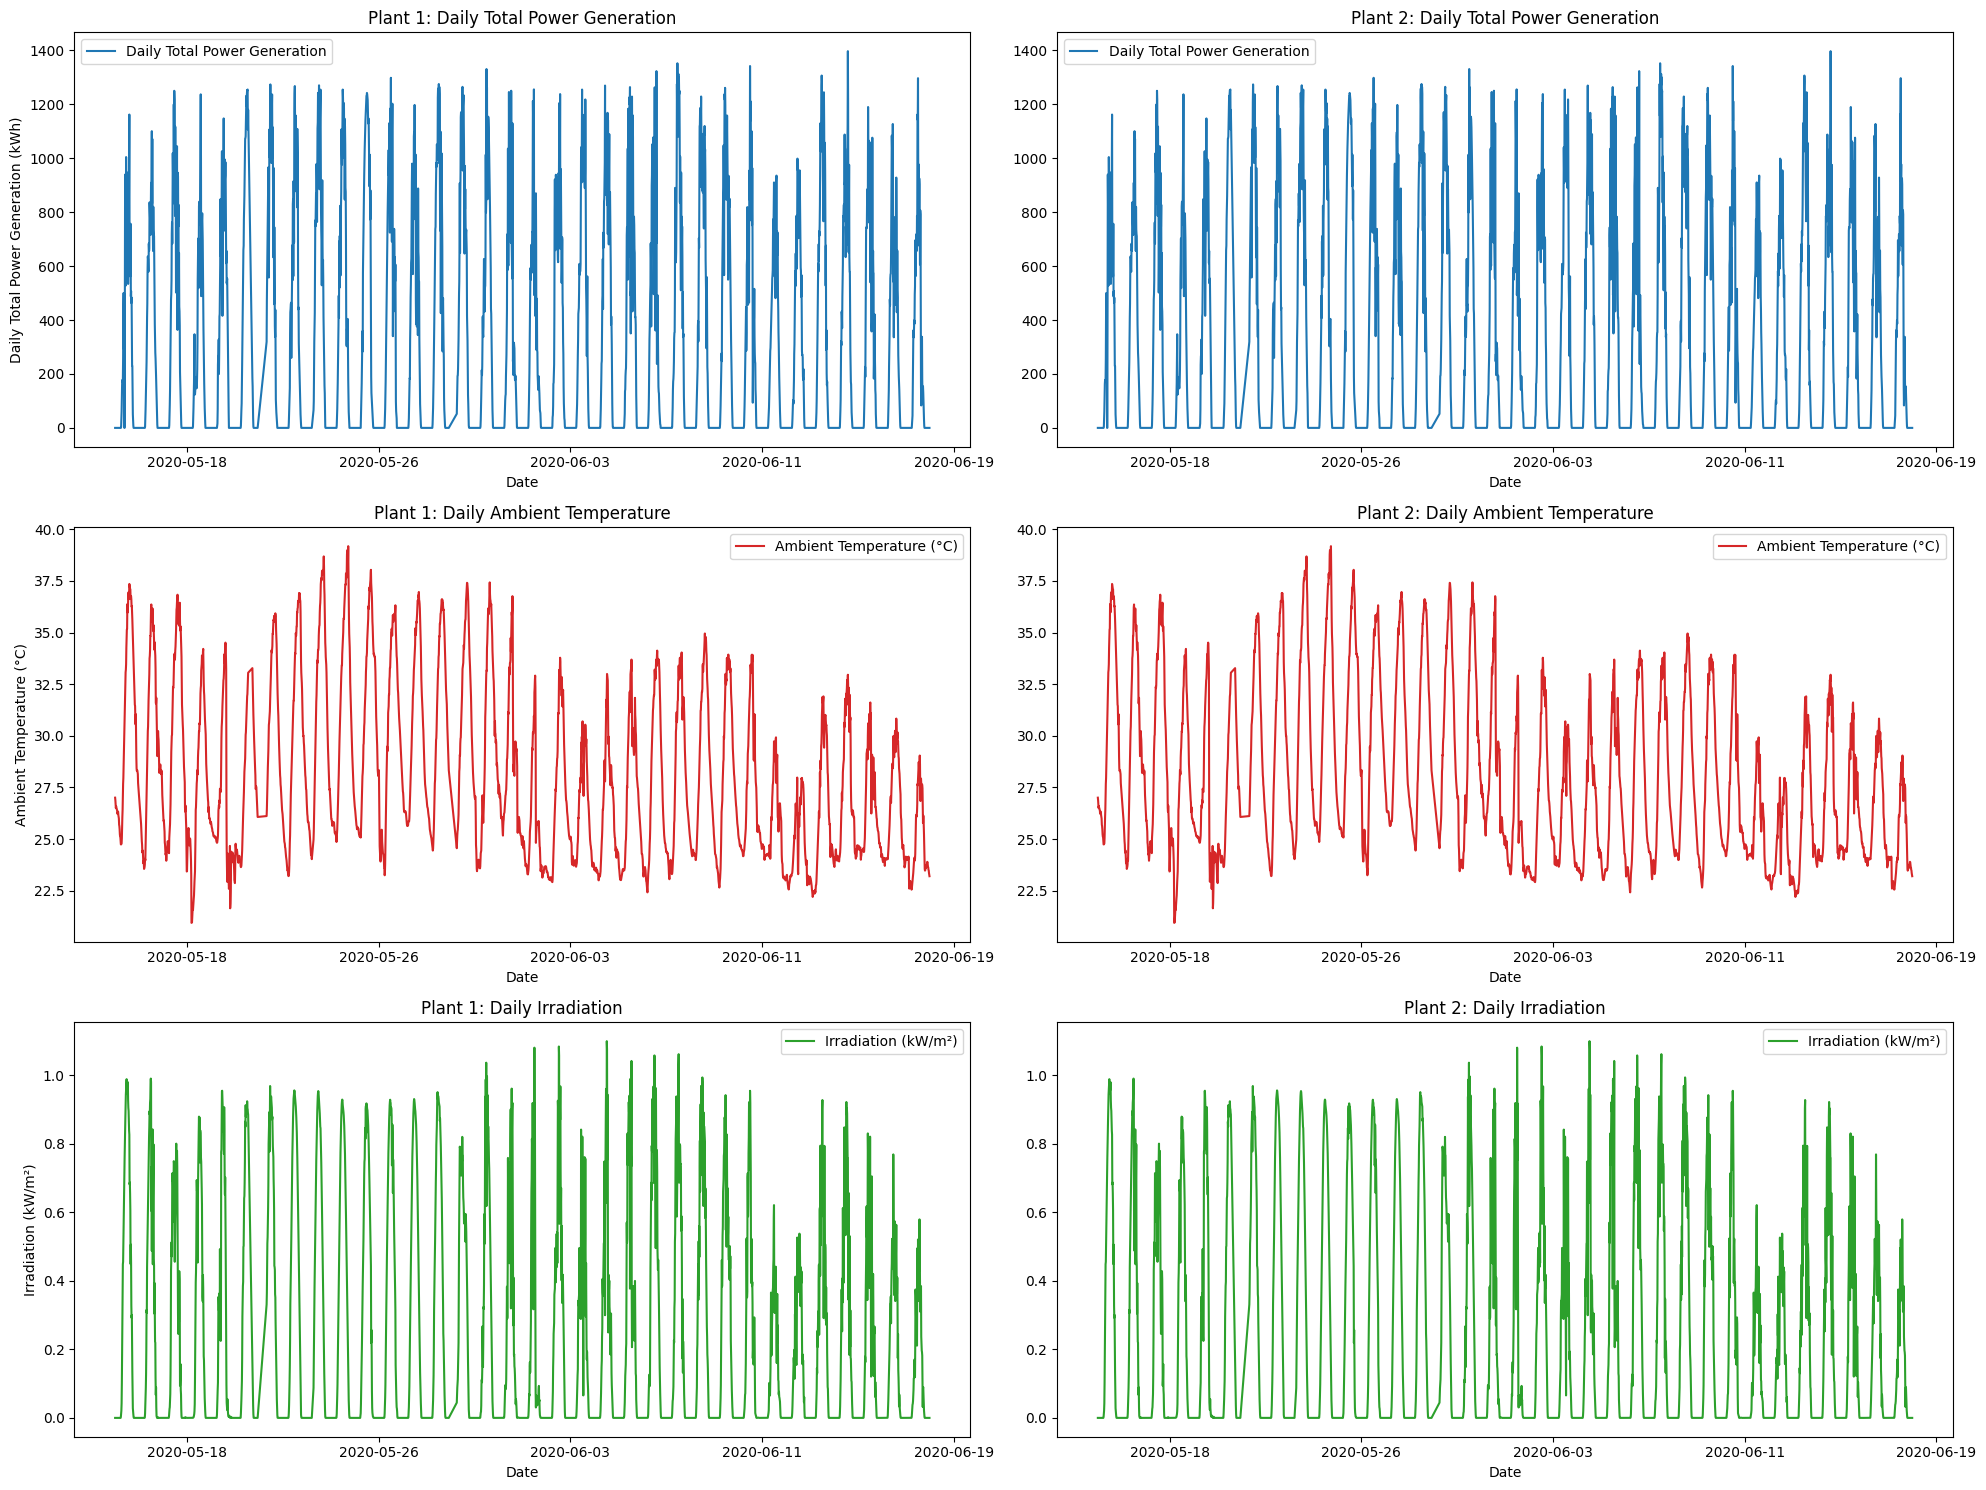

In [11]:
# Adjusting the layout to display Plant 1 and Plant 2 side by side for comparison

# Setting up the plot area for side-by-side comparison
fig, axs = plt.subplots(3, 2, figsize=(20, 15))

# Plant 1 Daily Total Power Generation
axs[0, 0].plot(
    plant_1_data["DATE_TIME"],
    plant_1_data["AC_POWER"],
    color="tab:blue",
    label="Daily Total Power Generation",
)
axs[0, 0].set_title("Plant 1: Daily Total Power Generation")
axs[0, 0].set_ylabel("Daily Total Power Generation (kWh)")
axs[0, 0].legend()

# Plant 2 Daily Total Power Generation
axs[0, 1].plot(
    plant_2_data["DATE_TIME"],
    plant_2_data["AC_POWER"],
    color="tab:blue",
    label="Daily Total Power Generation",
)
axs[0, 1].set_title("Plant 2: Daily Total Power Generation")
axs[0, 1].legend()

# Plant 1 Ambient Temperature
axs[1, 0].plot(
    plant_1_data["DATE_TIME"],
    plant_1_data["AMBIENT_TEMPERATURE"],
    color="tab:red",
    label="Ambient Temperature (°C)",
)
axs[1, 0].set_title("Plant 1: Daily Ambient Temperature")
axs[1, 0].set_ylabel("Ambient Temperature (°C)")
axs[1, 0].legend()

# Plant 2 Ambient Temperature
axs[1, 1].plot(
    plant_2_data["DATE_TIME"],
    plant_2_data["AMBIENT_TEMPERATURE"],
    color="tab:red",
    label="Ambient Temperature (°C)",
)
axs[1, 1].set_title("Plant 2: Daily Ambient Temperature")
axs[1, 1].legend()

# Plant 1 Irradiation
axs[2, 0].plot(
    plant_1_data["DATE_TIME"],
    plant_1_data["IRRADIATION"],
    color="tab:green",
    label="Irradiation (kW/m²)",
)
axs[2, 0].set_title("Plant 1: Daily Irradiation")
axs[2, 0].set_ylabel("Irradiation (kW/m²)")
axs[2, 0].legend()

# Plant 2 Irradiation
axs[2, 1].plot(
    plant_2_data["DATE_TIME"],
    plant_2_data["IRRADIATION"],
    color="tab:green",
    label="Irradiation (kW/m²)",
)
axs[2, 1].set_title("Plant 2: Daily Irradiation")
axs[2, 1].legend()

# Setting up the x-axis labels
for ax in axs.flat:
    ax.set_xlabel("Date")
    ax.xaxis.set_major_locator(
        plt.MaxNLocator(6)
    )  # Limit the number of x-axis labels to make them readable

plt.tight_layout()
plt.show()

### Correlation Matrix


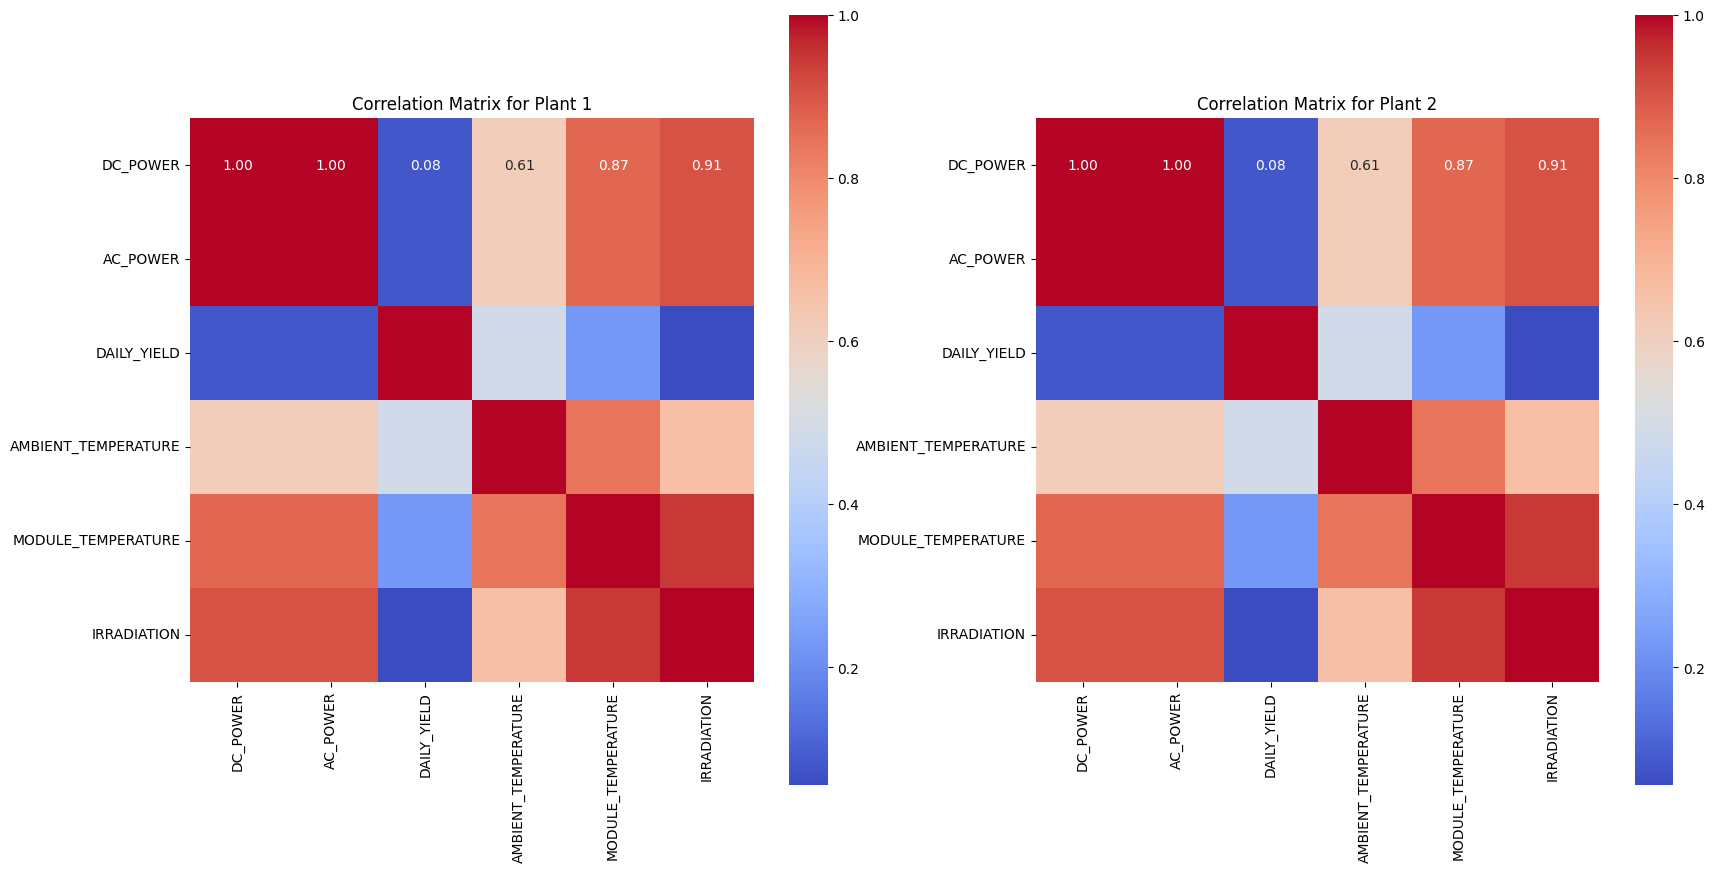

In [12]:
relevant_columns = [
    "DC_POWER",
    "AC_POWER",
    "DAILY_YIELD",
    "AMBIENT_TEMPERATURE",
    "MODULE_TEMPERATURE",
    "IRRADIATION",
]

correlation_matrix_1 = plant_1_data[relevant_columns].corr()
correlation_matrix_2 = plant_2_data[relevant_columns].corr()


plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.heatmap(correlation_matrix_1, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix for Plant 1")

plt.subplot(1, 2, 2)
sns.heatmap(correlation_matrix_2, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix for Plant 2")

plt.show()

## Prediction


### Preparation


In [13]:
# Preparing features and target variable
features = data_combined[["AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION"]]
target = data_combined["AC_POWER"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4415, 3) (4415,)
(1893, 3) (1893,)


In [14]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### SVM


In [15]:
# SVM Model Training
svm_model = SVR(kernel="rbf")
svm_model.fit(X_train_scaled, y_train)

# Predictions and Performance Evaluation
y_pred_svm = svm_model.predict(X_test_scaled)

# Calculating R^2 and MSE for the models
svm_score = svm_model.score(X_test_scaled, y_test) * 100
svm_r2 = r2_score(y_test, y_pred_svm) * 100
mse_svm = mean_squared_error(y_test, y_pred_svm)

print(f"SVM Model score = {svm_score:4.4f}%")
print(f"SVM Model R^2 = {svm_r2:4.4f}")
print(f"SVM Model MSE = {mse_svm:4.4f}")

SVM Model score = 78.3440%
SVM Model R^2 = 78.3440
SVM Model MSE = 33870.3913


### GBDT


In [16]:
# GBDT Model Training
gbdt_model = GradientBoostingRegressor()
gbdt_model.fit(X_train_scaled, y_train)

# Predictions and Performance Evaluation
y_pred_gbdt = gbdt_model.predict(X_test_scaled)

# Calculating R^2 and MSE for the models
gbdt_score = gbdt_model.score(X_test_scaled, y_test) * 100
gbdt_r2_score = r2_score(y_test, y_pred_gbdt) * 100
mse_gbdt = mean_squared_error(y_test, y_pred_gbdt)

print(f"GBDT Model score = {gbdt_score:4.4f}%")
print(f"GBDT Model R^2 score = {gbdt_r2_score:4.4f}")
print(f"GBDT Model MSE = {mse_gbdt:4.4f}")

GBDT Model score = 86.7929%
GBDT Model R^2 score = 86.7929
GBDT Model MSE = 20656.1744


### NNet


#### Data Transform


In [17]:
X_train_torch = torch.tensor(X_train_scaled.astype(np.float32))
y_train_torch = torch.tensor(y_train.values.astype(np.float32))
X_test_torch = torch.tensor(X_test_scaled.astype(np.float32))
y_test_torch = torch.tensor(y_test.values.astype(np.float32))


train_data = TensorDataset(X_train_torch, y_train_torch)
test_data = TensorDataset(X_test_torch, y_test_torch)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

#### Model


In [18]:
class NNet(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(NNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        return x


model = NNet(3, 128, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 200
for epoch in range(epochs):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.view(-1, 1))
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


# Model Evaluation
model.eval()
predictions = []
targets = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        predictions.extend(output.view(-1).tolist())
        targets.extend(target.tolist())

nnet_r2 = r2_score(targets, predictions) * 100
print(f"NNet R^2 Score: {nnet_r2}")

Epoch 1, Loss: 231671.6875
Epoch 2, Loss: 107625.0859375
Epoch 3, Loss: 42792.71484375
Epoch 4, Loss: 23477.990234375
Epoch 5, Loss: 20777.4921875
Epoch 6, Loss: 33719.28515625
Epoch 7, Loss: 20432.927734375
Epoch 8, Loss: 15869.3193359375
Epoch 9, Loss: 31161.05859375
Epoch 10, Loss: 31468.232421875
Epoch 11, Loss: 14797.4326171875
Epoch 12, Loss: 24137.7265625
Epoch 13, Loss: 21036.572265625
Epoch 14, Loss: 31183.7890625
Epoch 15, Loss: 16306.349609375
Epoch 16, Loss: 20628.5234375
Epoch 17, Loss: 20557.44140625
Epoch 18, Loss: 27069.400390625
Epoch 19, Loss: 14692.4716796875
Epoch 20, Loss: 22213.111328125
Epoch 21, Loss: 28852.869140625
Epoch 22, Loss: 25713.33984375
Epoch 23, Loss: 13684.5380859375
Epoch 24, Loss: 23827.109375
Epoch 25, Loss: 32055.732421875
Epoch 26, Loss: 30644.669921875
Epoch 27, Loss: 28056.25390625
Epoch 28, Loss: 30462.365234375
Epoch 29, Loss: 16877.994140625
Epoch 30, Loss: 11280.3330078125
Epoch 31, Loss: 26202.3671875
Epoch 32, Loss: 15502.8193359375
Epo

In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.hidden2out = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        lstm_out, _ = self.lstm(input.view(len(input), 1, -1))
        output = self.hidden2out(lstm_out.view(len(input), -1))
        return output


model = LSTM(3, 128, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 200
for epoch in range(epochs):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.view(-1, 1))
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


# Model Evaluation
model.eval()
predictions = []
targets = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        predictions.extend(output.view(-1).tolist())
        targets.extend(target.tolist())

lstm_r2 = r2_score(targets, predictions) * 100
print(f"LSTM R^2 Score: {lstm_r2}")

Epoch 1, Loss: 253052.40625
Epoch 2, Loss: 134262.71875
Epoch 3, Loss: 263438.0625
Epoch 4, Loss: 243066.625
Epoch 5, Loss: 235528.25
Epoch 6, Loss: 244635.421875
Epoch 7, Loss: 261555.71875
Epoch 8, Loss: 299636.46875
Epoch 9, Loss: 250729.4375
Epoch 10, Loss: 213975.25
Epoch 11, Loss: 214787.765625
Epoch 12, Loss: 172980.34375
Epoch 13, Loss: 251918.53125
Epoch 14, Loss: 219333.59375
Epoch 15, Loss: 174294.828125
Epoch 16, Loss: 211256.546875
Epoch 17, Loss: 178260.03125
Epoch 18, Loss: 174466.796875
Epoch 19, Loss: 121141.0078125
Epoch 20, Loss: 135744.609375
Epoch 21, Loss: 220103.078125
Epoch 22, Loss: 134846.84375
Epoch 23, Loss: 129303.5546875
Epoch 24, Loss: 182233.453125
Epoch 25, Loss: 111117.2734375
Epoch 26, Loss: 151398.796875
Epoch 27, Loss: 129586.1875
Epoch 28, Loss: 101500.3515625
Epoch 29, Loss: 98443.7109375
Epoch 30, Loss: 129068.3359375
Epoch 31, Loss: 132831.15625
Epoch 32, Loss: 154817.703125
Epoch 33, Loss: 156510.203125
Epoch 34, Loss: 112153.78125
Epoch 35, Lo